In [1]:
import torch
from matplotlib import pyplot as plt
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

In [2]:
root_path = "/home/yigit/projects/mbcnp/outputs/baxter/"
suffix = 'js'
run_id, model_folder = f'1697545705_{suffix}', '/saved_models/'
models_path = f'{root_path}{run_id}{model_folder}'

cnp_model_path, wta_model_path = f'{models_path}cnp_on_synth.pt', f'{models_path}wta_on_synth.pt'

raw_data_path = '/home/yigit/projects/mbcnp/data/baxter/'

In [3]:
y = torch.load(f'{root_path}{run_id}/y.pt').cpu()
num_samples, t_steps, dy = y.shape

x = torch.linspace(0, 1, 200).repeat(num_samples, 1).view(num_samples, -1, 1)
colors = ['tomato', 'aqua', 'limegreen', 'gold', 'mediumslateblue', 'lightcoral', 'darkorange', 'teal']

from matplotlib import pyplot as plt

fig, axs = plt.subplots(dy, 1, figsize=(7, 25))
for i in range(num_samples):
    for j in range(dy):
        axs[j].plot(x[i, :, 0].cpu(), y[i, :, j].cpu(), label=f'Demonstration {i+1}')
        axs[j].grid(True)
        axs[j].legend()

        axs[j].set_xlabel('Time (t)')
        axs[j].set_ylabel('SM(t)')
        axs[j].set_title(f'DoF #{j+1}')

plt.tight_layout()
plt.savefig(f'{raw_data_path}data_{}.png')
plt.close()

In [4]:
batch_size = 6
cnp = CNP(input_dim=1, hidden_dim=158, output_dim=2, n_max_obs=6, n_max_tar=6, num_layers=3, batch_size=batch_size)
wta = WTA_CNP(1, 2, 6, 6, [128, 128, 128], num_decoders=2, decoder_hidden_dims=[128, 128, 128], batch_size=batch_size)

cnp.load_state_dict(torch.load(cnp_model_path))
wta.load_state_dict(torch.load(wta_model_path))

cnp.eval()
wta.eval()

WTA_CNP(
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoders): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=129, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=4, bias=True)
    )
  )
  (gate): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [5]:
import os
import csv

def get_batch(idx=[0, -1], cond_idx=[0]):

    batch_obs = torch.zeros(batch_size, len(cond_idx), dy+1)
    batch_obs[:, :, 0] = x[0, cond_idx, 0]

    raw_data = []
    for demo_file in sorted(os.listdir(raw_data_path)):
        if demo_file.endswith('.csv'):
            d = os.path.join(raw_data_path, demo_file)

            temp_data = []
            
            with open(d, 'r') as f:
                for i, line in enumerate(csv.reader(f)):
                    if i > 0:
                        # temp_data.append([float(line[-7]), float(line[-6]), float(line[-5]), float(line[-4]), float(line[-3]), float(line[-2]), float(line[-1])])
                        temp_data.append([float(line[3]), float(line[4])])

            raw_data.append(temp_data)

    demonstration = []
    for i in range(len(raw_data)):
        traj = raw_data[i]
        processed_traj = []
        inds = torch.linspace(0, len(traj)-1, t_steps, dtype=int)
        for ind in inds:
            processed_traj.append(traj[ind])

        demonstration.append(processed_traj)

    batch_y = torch.tensor(demonstration, dtype=torch.float32)

    batch_obs[:, :, 1:] = batch_y[idx, cond_idx, :].view(batch_size, len(cond_idx), dy)
    # for i in range(batch_size):
    #     batch_obs[i, 0, 0] = x[i, cond_idx[0], 0]
    #     batch_obs[i, 0, 1:] = batch_y[i, cond_idx[0], :]
    return batch_obs, batch_y[idx, :, :]




In [6]:
# obs = torch.Tensor([1.0, 0.0]).unsqueeze(0).unsqueeze(0)
test_ind = 0
# obs = torch.zeros(batch_size, 1, 1+dy)
# for i in range(batch_size):
#     obs[i, 0, 0] = x[i, test_ind, 0]
#     obs[i, 0, 1:] = y[i, test_ind, :]

# real_y = y

tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).repeat(batch_size, 1, 1)
# print(obs.shape, tar.shape)

obs, real_y = get_batch(list(range(6)), [test_ind])

print(obs.shape, real_y.shape, tar.shape)

with torch.no_grad():
    pred_cnp, _ = cnp(obs, tar)
    pred_wta, gate = wta(obs, tar)


# print(obs)
print(pred_wta.shape, pred_cnp.shape, gate.shape, real_y.shape)
# print(gate)

torch.Size([6, 1, 3]) torch.Size([6, 200, 2]) torch.Size([6, 200, 1])
torch.Size([2, 6, 200, 4]) torch.Size([6, 200, 4]) torch.Size([6, 1, 2]) torch.Size([6, 200, 2])


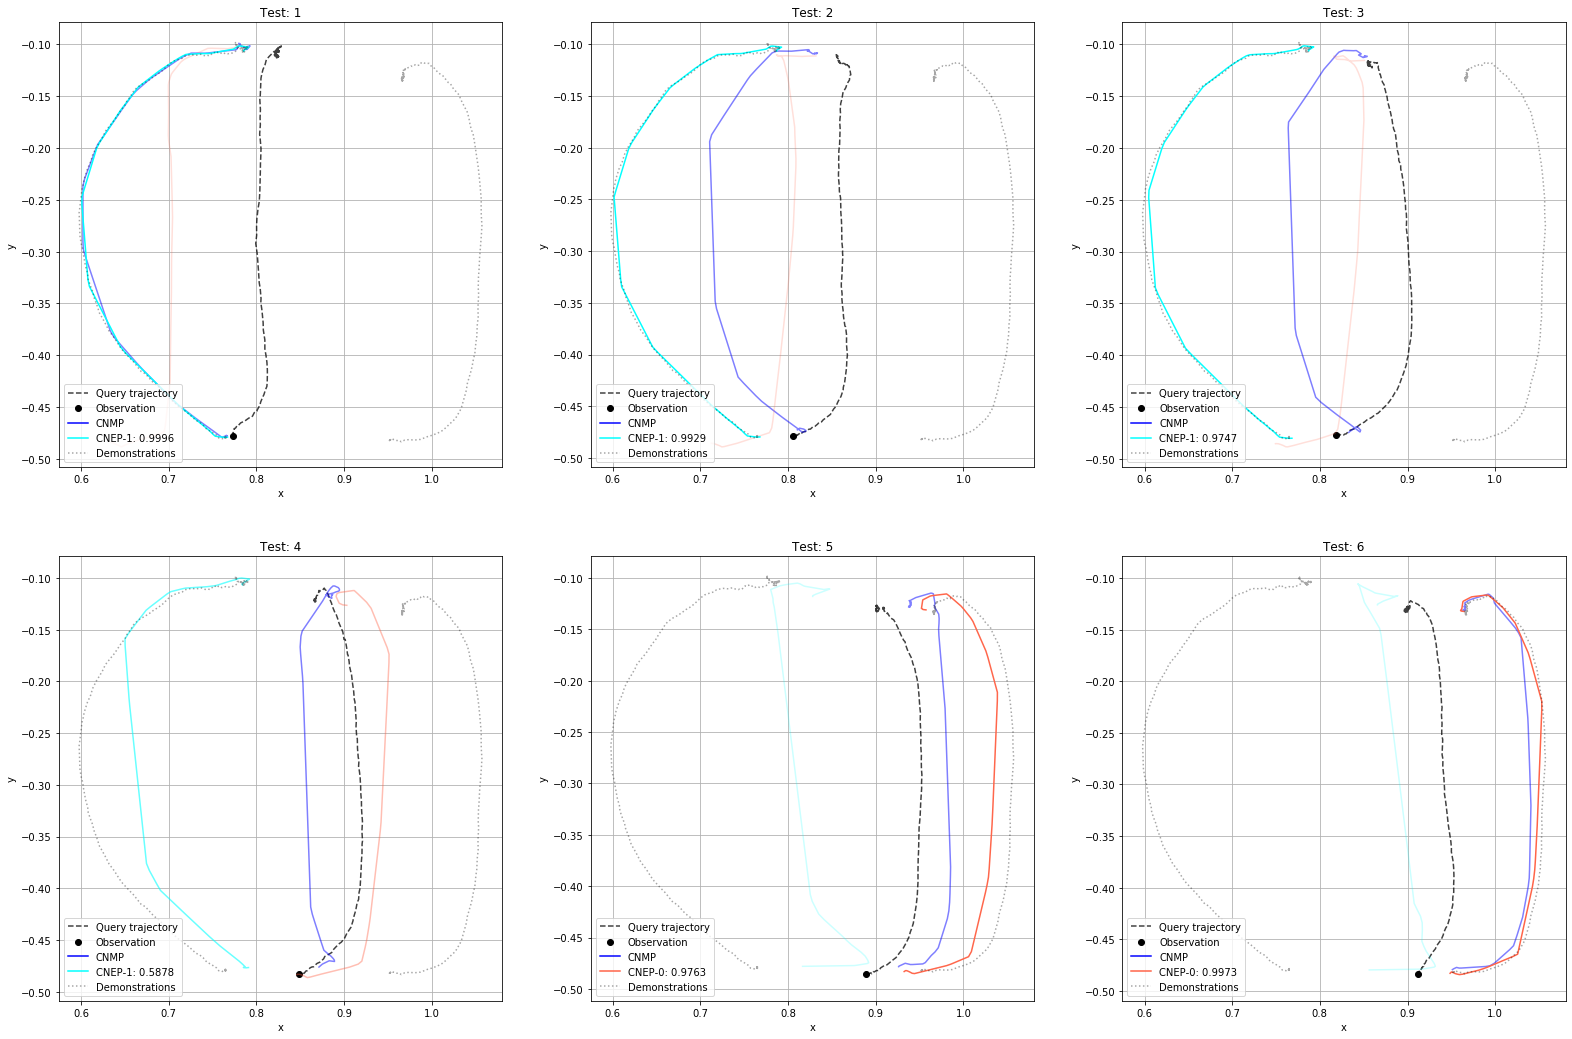

In [19]:
from matplotlib.lines import Line2D


def plot_cnp_wta_dim():
    rows, cols = torch.floor(torch.sqrt(torch.tensor(batch_size))).int(), torch.ceil(torch.sqrt(torch.tensor(batch_size))).int()
    ax_rows, ax_cols = rows.item()*dy, cols.item()  # 7, 2
    fig, axs = plt.subplots(ax_rows, ax_cols, figsize=(12, 12))
    for i in range(ax_rows):  # 7
        for j in range(ax_cols):  # 2
            axs[i, j].scatter(obs[j, :, 0], obs[j, :, i+1], label='Observation', c='k')
            # axs[i, j].set_ylim((plt_y_lower_lim, plt_y_upper_lim))
            axs[i, j].plot(x[j], real_y[j,:,i], 'k--', alpha=0.75, label='Query trajectory')  # data
            
            axs[i, j].plot(x[j], pred_cnp[j,:,i], 'b', alpha=0.5)  # cnp predictions

            handles = axs[i, j].get_legend_handles_labels()[0]
            handles.extend([Line2D([0], [0], label='CNMP', color='b')])

            best = torch.argmax(gate[j, 0, :]).item()
            for k in range(gate.shape[-1]):
                axs[i, j].plot(x[j], pred_wta[k,j,:,i], colors[k%batch_size], alpha=max(0.2, gate[j, 0, k].item()))  # wta predictions
                if k==best:
                    handles.extend([Line2D([0], [0], label=f'CNEP-{k}: {gate[j, 0, k].item():.4f}', color=colors[k])])

            axs[i, j].plot(x[j], y[j,:,i], 'k--', alpha=0.35, label='demo_traj_0')  # data
            axs[i, j].plot(x[j], y[1-j,:,i], 'k--', alpha=0.35, label='demo_traj_1')  # data
            handles.extend([Line2D([0], [0], label='demo_traj_0', alpha=0.35, color='k')])
            handles.extend([Line2D([0], [0], label='demo_traj_1', alpha=0.35, color='k')])

            axs[i, j].legend(handles=handles, loc='best')
            axs[i, j].set_title(f'Demo: {j+1}, Dim: {i+1}')
            axs[i, j].grid(True)


def determine_subplot_index(i, j, ax_rows):
    if ax_rows == 1:
        return j
    else:
        return i, j

def plot_cnp_wta_xy():
    rows, cols = torch.floor(torch.sqrt(torch.tensor(batch_size))).int(), torch.ceil(torch.sqrt(torch.tensor(batch_size))).int()
    ax_rows, ax_cols = rows.item(), cols.item()  
    fig, axs = plt.subplots(ax_rows, ax_cols, figsize=(ax_cols*9, ax_rows*9))
    for i in range(ax_rows):
        for j in range(ax_cols):
            ind = i*ax_cols + j

            subplot_index = determine_subplot_index(i,j,ax_rows)

            axs[subplot_index].scatter(obs[ind, :, 1], obs[ind, :, 2], label='Observation', c='k')
            axs[subplot_index].plot(real_y[ind,:,0], real_y[ind,:,1], 'k--', alpha=0.75, label='Query trajectory')  # data
            
            axs[subplot_index].plot(pred_cnp[ind,:,0], pred_cnp[ind,:,1], 'b', alpha=0.5)  # cnp predictions

            handles = axs[subplot_index].get_legend_handles_labels()[0]
            handles.extend([Line2D([0], [0], label='CNMP', color='b')])

            best = torch.argmax(gate[ind, 0, :]).item()
            for k in range(gate.shape[-1]):
                axs[subplot_index].plot(pred_wta[k,ind,:,0], pred_wta[k,ind,:,1], colors[k%batch_size], alpha=max(0.2, gate[ind, 0, k].item()))  # wta predictions
                if k==best:
                    handles.extend([Line2D([0], [0], label=f'CNEP-{k}: {gate[ind, 0, k].item():.4f}', color=colors[k])])

            axs[subplot_index].plot(y[0,:,0], y[0,:,1], 'k:', alpha=0.35)  # data
            axs[subplot_index].plot(y[1,:,0], y[1,:,1], 'k:', alpha=0.35)  # data
            handles.extend([Line2D([0], [0], label='Demonstrations', alpha=0.35, color='k', linestyle='dotted')])

            axs[subplot_index].legend(handles=handles, loc='lower left')
            axs[subplot_index].set_title(f'Test: {ind+1}')
            axs[subplot_index].grid(True)
            axs[subplot_index].set_xlabel('x')
            axs[subplot_index].set_ylabel('y')
            

    plt.savefig(f'{root_path}{run_id}/traj_generation.png')
    plt.show()

plot_cnp_wta_xy()